# Predicting the Air Quality Index and the Health Risk Index of Indian Cities using Machine Learning
<hr/>

**Goal of the Project**

Air is what keeps humans alive. Monitoring it and understanding its quality is of immense importance to our well-being. In this Project, We use our data analysis and machine learning skills to forecast the AQI and HRI for major Indian AQI stations for the upcoming 28 days. The dataset consists of the historical daily average of several air pollutants which directly affect the Air Quality Index.


In [1]:
import io
import base64
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from matplotlib import dates as mdates
from collections import defaultdict

%matplotlib inline
pd.options.display.max_rows = 500

## 1. Data Description

The dataset consists of historical daily average pollutants, including NO2, CO, PM2.5, and other important factors that affect the air quality index. Keep in mind that different AQI stations have different lengths of historical data. our challenge in this is to forecast average AQI levels across different stations in Taminadu for the next 28 days.

<hr/>

**train.csv** - 2 years of historical data for 12 Indian AQI stations


*   `StateCode`: State where the AQI station is located
*   `StationId`: AQI station ID
*   `Date`: Date when the observations where recorded
*   `PM2.5`: Average PM2.5 pollutant level
*   `PM10`: Average PM10 pollutant level
*   `O3`: Average O3 pollutant level
*   `CO`: Average CO pollutant level
*   `NO2`: Average NO2 pollutant level
*   `AQI`: Average Air Quality Index - target variable
*   `HRI`: Average Health Risk Index - target variable


**State Description**:

| StateCode | State Name |
| :---: | :---: |
| TN | Tamil Nadu |



<hr/>

**Evaluation Metric**:

Model is evaluated on Mean Absolute Error (MAE) , root mean square error(rmse), r2_score, mean absolute percentage error (mape) between forecasts and the actual values.


Let's understand what some of the features actually mean? What are their ranges and what is it's significance!

*   `PM2.5`:
    *   Fine particulate matter (PM2.5) is an air pollutant that is a concern for people's health when levels in air are high.
    *   PM2.5 are tiny particles in the air that reduce visibility and cause the air to appear hazy when levels are elevated.
    *   Outdoor PM2.5 levels are most likely to be elevated on days with little or no wind or air mixing.
    *   These tiny particles or droplets in the air that are two and one half microns or less in width. Like inches, meters and miles, a micron is a unit of measurement for distance. There are about 25,000 microns in an inch.
    *   Most studies indicate PM2.5 at or below 12 μg/m3 is considered healthy with little to no risk from exposure. If the level goes to or above 35 μg/m3 during a 24-hour period, the air is considered unhealthy and can cause issues for people with existing breathing issues such as asthma. Prolonged exposure to levels above 50 μg/m3 can lead to serious health issues and premature mortality.
    *   [Fine Particles (PM 2.5) Questions and Answers](https://www.indoorairhygiene.org/pm2-5-explained/#:~:text=Most%20studies%20indicate%20PM2.,breathing%20issues%20such%20as%20asthma.) - Department of Health NY
    *   [PM2.5 Explained](https://www.indoorairhygiene.org/pm2-5-explained/#:~:text=Most%20studies%20indicate%20PM2.,breathing%20issues%20such%20as%20asthma.) - Indoor Air Hygiene Institute

*   `PM10`:
    *   PM10 includes particles less than 10 µm in diameter, PM2.5 those less than 2.5 µm. *Therefore, PM2.5 comprises a portion of PM10.*
    *   PM10 and PM2.5 often derive from different emissions sources, and also have different chemical compositions.
    *   Emissions from combustion of gasoline, oil, diesel fuel or wood produce much of the PM2.5 pollution found in outdoor air, as well as a significant proportion of PM10.
    *   PM10 also includes dust from construction sites, landfills and agriculture, wildfires and brush/waste burning, industrial sources, wind-blown dust from open lands, pollen and fragments of bacteria.
    *   [Inhalable Particulate Matter and Health (PM2.5 and PM10)](https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health) - California Air Resources Board

| <img src="https://ww2.arb.ca.gov/sites/default/files/inline-images/human_hair_0.png" width=700 height=500/ align="center" /> |
|:--:|
| Credit: [California Air Resources Board](https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health) |


*   `O3`:
    *   Ozone is a pale blue gas, soluble in water and non-polar solvents with specific sharp odor somewhat resembling chlorine bleach.
    *   Ozone cracking in car tires, gaskets, O-rings is caqused by attack of ozone on any polymer possessing olefinic or double bonds within its chain structure.

*   `CO`:
    *   Carbonous oxide, is a colorless, odorless and tasteless gas which is slightly lighter than air.
    *   It is highly toxic to humans and animals in higher quantities. Mainly formed by incomplete combustion of carbon containing fuels.

*   `NO2`:
    *  NO₂, or nitrogen dioxide, is a reddish-brown gas with a characteristic sharp, biting odor. It's an important air pollutant due to its significant effects on human health and the environment..

*   Revised National Ambient Air Quality Standards (NAAQS) [NAAQS Notification dated 18th November, 2009] [(Refer Page 90-97)](https://cpcb.nic.in/upload/NAAQS_2019.pdf):

|S. No.|Pollutants|Time Weighted Average|Concentration in Ambient Air| |
|:---:|:---:|:---:|:---:|:---:|
| | | |Industrial,Residential, Rural and other Areas|Ecologically Sensitive Area (notified by Central Government)|
|1|Sulphur Dioxide (SO2)|Annual|50|20|
| | |24 Hours|80|80|
|2|Nitrogen Dioxide (NO2)|Annual|40|30|
| | |24 Hours|80|80|
|3|Particulate Matter (PMIO)|Annual|60|60|
| | |24 Hours|100|100|
|4|Particulate Matter (PM2.5)|Annual|40|40|
| | |24 Hours|60|60|
|5|Ozone (03), pg/m3|8 hours|100|100|
| | |1 hours|180|180|
|6|Carbon Monoxide (CO),|8 Hours|2|2|
| | |1 Hour|4|4|


In [57]:
# Read the datasets
train = pd.read_csv("train_processed.csv")

In [46]:
train.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,NO2,CO,O3,Unnamed: 9
0,TN_1_2023-01-01,TN,1,2023-01-01,79.766111,122.725278,32.642292,0.962743,28.797257,NaN
1,TN_1_2023-01-02,TN,1,2023-01-02,65.267917,100.412118,27.493611,0.893368,24.596701,NaN
2,TN_1_2023-01-03,TN,1,2023-01-03,77.221597,118.804028,31.605174,0.928056,31.218576,NaN
3,TN_1_2023-01-04,TN,1,2023-01-04,79.024062,121.557465,40.679722,0.780868,41.943681,NaN
4,TN_1_2023-01-05,TN,1,2023-01-05,67.057500,103.164236,38.564236,0.808125,70.557951,NaN


## 2. Basic Statistics

In [7]:
print(f"Training dataset has {train.shape[0]} rows and {train.shape[1]} columns")

Training dataset has 8772 rows and 10 columns


In [47]:
train.columns

Index(['ID_Date', 'StateCode', 'StationId', 'Date', 'PM2.5', 'PM10', 'NO2',
       'CO', 'O3', 'Unnamed: 9'],
      dtype='object')

In [48]:

train.drop('Unnamed: 9', axis=1, inplace=True)

In [49]:
train.describe()

,StationId,PM2.5,PM10,NO2,CO,O3
count,8772.000000,7442.000000,7636.000000,7398.000000,7690.000000,7701.000000
mean,6.500000,27.792892,62.108542,19.270074,0.773751,13.088276
std,3.452249,22.902029,37.993219,21.841273,0.556158,13.470276
min,1.000000,0.048125,1.340000,0.010000,0.001000,0.215833
25%,3.750000,14.252500,37.507652,7.198438,0.442543,5.289022
50%,6.500000,22.444688,55.005000,13.400388,0.640000,8.080000
75%,9.250000,35.547609,77.772500,22.395163,0.930000,14.983021
max,12.000000,995.000000,916.714687,224.254130,7.449603,185.760000


We find:


* Different Counts

Each pollutant (PM2.5, PM10, NO2, CO, O3) has a different number of valid records (count). For example, PM2.5 has 7442 valid data points, while PM10 has 7636. This indicates missing values in some columns.

* Range and Potential Outliers

PM2.5 ranges from about 0.048 to nearly 995, and PM10 goes up to 916.7. Those maxima are extremely high compared to their respective medians (22.44 for PM2.5 and 53 for PM10).
This large gap between the 75% percentile and the maximum suggests there could be significant outliers or high pollution episodes for both PM2.5 and PM10.
Similarly, NO2, CO, and O3 also show large maxima relative to their means (e.g., NO2 max ~224, CO max ~7.47, O3 max ~186), again hinting at possible spikes or outliers.

* Central Tendency and Spread

The means for PM2.5 (27.79), PM10 (62.11), NO2 (19.27), CO (0.77), and O3 (13.87) differ from their medians, implying skewed distributions (likely right-skewed, given those high maximum values).
Standard deviations are quite high for PM2.5 (22.90), PM10 (37.99), and NO2 (21.84), which supports the notion that these columns have a wide spread and potential extreme values.

* Station IDs

StationId ranges from 1 to 12 with a mean of about 6.5. That simply confirms you have data from 12 stations. The total row count (8772) indicates the full dataset size.

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8772 entries, 0 to 8771
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID_Date    8772 non-null   object 
 1   StateCode  8772 non-null   object 
 2   StationId  8772 non-null   int64  
 3   Date       8772 non-null   object 
 4   PM2.5      7442 non-null   float64
 5   PM10       7636 non-null   float64
 6   NO2        7398 non-null   float64
 7   CO         7690 non-null   float64
 8   O3         7701 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 616.9+ KB


We find:

*   `PM2.5`, `PM10`, `O3`, `CO`, `NO2` - These are numeric (float64) columns.
*   `StationId`: It is a numeric (int64) column.
*   `ID_Date`, `StateCode`, `Date` - These columns are of type object.
*   There are some missing values present in the dataset.

In [51]:
train.groupby(by=["StateCode"]).StationId.nunique()

,StationId
StateCode,
TN,12


In [52]:
train.groupby(by=["StateCode"]).StationId.nunique().sum()

12

## 3. Data Preprocessing

In [53]:
from sklearn.impute import KNNImputer

train['Date'] = pd.to_datetime(train['Date'])

num_cols = ['PM2.5', 'PM10', 'NO2', 'CO', 'O3']

imputer = KNNImputer(n_neighbors=5, weights="uniform")

train[num_cols] = imputer.fit_transform(train[num_cols])

print("Missing values handled using KNN Imputer.")

Missing values handled using KNN Imputer.


In [54]:
# Function to cap outliers using IQR method
def cap_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping outliers
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# Apply IQR capping
train = cap_outliers(train, num_cols)

print("Outliers handled using IQR method")


Outliers handled using IQR method. File saved as train_outliers_handled.csv


In [55]:
# Apply log transformation (adding 1 to avoid log(0))
for col in num_cols:
    train[col] = np.log1p(train[col])  # log1p is log(1 + x) to handle zeros safely
print("Data normalized using log transformation")

Data normalized using log transformation


In [56]:
train.to_csv("train_processed.csv", index=False)

## 3. Exploratory Data Analysis

In [58]:
train.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,NO2,CO,O3
0,TN_1_2023-01-01,TN,1,2023-01-01,4.135584,4.818064,3.515784,0.674343,3.316692
1,TN_1_2023-01-02,TN,1,2023-01-02,4.135584,4.619193,3.349680,0.638357,3.242463
2,TN_1_2023-01-03,TN,1,2023-01-03,4.135584,4.785857,3.484471,0.656512,3.316692
3,TN_1_2023-01-04,TN,1,2023-01-04,4.135584,4.808580,3.730015,0.577101,3.316692
4,TN_1_2023-01-05,TN,1,2023-01-05,4.135584,4.645969,3.677926,0.592290,3.316692


In [59]:
# Check for missing values
train.isnull().sum().sort_values(ascending=False)

,0
ID_Date,0
StateCode,0
StationId,0
Date,0
PM2.5,0
PM10,0
NO2,0
CO,0
O3,0


In [60]:
train.StateCode.value_counts()

,count
StateCode,
TN,8772


In [61]:
train.StationId.nunique()

12

In [62]:
train.StationId.value_counts()

,count
StationId,
1,731
2,731
3,731
4,731
5,731
6,731
7,731
8,731
9,731


In [63]:
# Check out the rows containing the missing values
train[train.isnull().any(axis=1)].sort_values(by=['StateCode', 'Date'])

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,NO2,CO,O3


In [64]:
train.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,NO2,CO,O3
0,TN_1_2023-01-01,TN,1,2023-01-01,4.135584,4.818064,3.515784,0.674343,3.316692
1,TN_1_2023-01-02,TN,1,2023-01-02,4.135584,4.619193,3.349680,0.638357,3.242463
2,TN_1_2023-01-03,TN,1,2023-01-03,4.135584,4.785857,3.484471,0.656512,3.316692
3,TN_1_2023-01-04,TN,1,2023-01-04,4.135584,4.808580,3.730015,0.577101,3.316692
4,TN_1_2023-01-05,TN,1,2023-01-05,4.135584,4.645969,3.677926,0.592290,3.316692


In [65]:
# Look at since when the data was collected for state. Also, till when was the data collected.
grouped = train.groupby(by=["StationId"])

start_dates = grouped.Date.min()
end_dates = grouped.Date.max()

date_df = pd.DataFrame(list(zip(start_dates.values, end_dates.values)), index=start_dates.index.values, columns=["StartDate", "EndDate"]).sort_values("StartDate")

date_df.StartDate = date_df.StartDate.apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
date_df.EndDate = date_df.EndDate.apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

date_df['Difference'] = date_df.EndDate - date_df.StartDate

In [66]:
date_df

,StartDate,EndDate,Difference
1,2023-01-01,2024-12-31,730 days
2,2023-01-01,2024-12-31,730 days
3,2023-01-01,2024-12-31,730 days
4,2023-01-01,2024-12-31,730 days
5,2023-01-01,2024-12-31,730 days
6,2023-01-01,2024-12-31,730 days
7,2023-01-01,2024-12-31,730 days
8,2023-01-01,2024-12-31,730 days
9,2023-01-01,2024-12-31,730 days
10,2023-01-01,2024-12-31,730 days


In [67]:
# Check the statistics for releveant features
relevant_cols = ['PM2.5', 'PM10', 'O3', 'CO', 'NO2']

In [68]:
# Mean statewise
grouped[relevant_cols].agg(['mean', 'median'])

PM2.5                PM10                  O3            \
               mean    median      mean    median      mean    median   
StationId                                                               
1          3.515120  3.632309  4.133213  4.144856  2.548025  2.640507   
2          3.293928  3.360129  4.019863  4.144856  2.242975  1.978470   
3          2.692921  2.679641  4.055866  4.128478  2.548165  2.645343   
4          3.347894  3.386760  4.029562  4.087823  2.950956  3.071303   
5          3.216355  3.293732  3.882995  3.947621  1.888343  1.832188   
6          3.059992  3.022455  4.123851  4.172141  2.333850  2.406044   
7          2.930542  2.965763  3.752074  3.790307  2.339933  2.645343   
8          3.064821  3.060271  3.986774  4.070450  2.430741  2.337252   
9          3.288829  3.360129  3.952288  4.107425  1.755853  1.435085   
10         2.918179  3.170526  4.093254  4.144856  2.324920  2.047693   
11         3.260810  3.299165  3.920052  3.969510  2.771991  3.055886   
12         3.381868  3.360129  4.113339  4.144856  1.463655  0.944360   

                 CO                 NO2            
               mean    median      mean    median  
StationId                                          
1          0.735173  0.806476  3.073799  3.229618  
2          0.527333  0.573097  3.074439  3.009146  
3          0.526015  0.524503  2.688425  2.726740  
4          0.769860  0.821843  2.551630  2.524928  
5          0.354525  0.329304  2.208063  2.327396  
6          0.473267  0.456743  1.918941  1.880991  
7          0.328336  0.329304  1.802257  1.308333  
8          0.501186  0.500775  3.022074  3.056357  
9          0.533409  0.559616  3.297499  3.100615  
10         0.510456  0.524729  2.674124  2.740849  
11         0.605032  0.612743  2.896263  2.893700  
12         0.366839  0.332894  2.850880  2.912894

In [69]:
state_station_group = train.groupby(by=['StateCode', 'StationId'])

In [70]:
state_station_group[relevant_cols].agg(['mean', 'median'])

PM2.5                PM10                  O3  \
                         mean    median      mean    median      mean   
StateCode StationId                                                     
TN        1          3.515120  3.632309  4.133213  4.144856  2.548025   
          2          3.293928  3.360129  4.019863  4.144856  2.242975   
          3          2.692921  2.679641  4.055866  4.128478  2.548165   
          4          3.347894  3.386760  4.029562  4.087823  2.950956   
          5          3.216355  3.293732  3.882995  3.947621  1.888343   
          6          3.059992  3.022455  4.123851  4.172141  2.333850   
          7          2.930542  2.965763  3.752074  3.790307  2.339933   
          8          3.064821  3.060271  3.986774  4.070450  2.430741   
          9          3.288829  3.360129  3.952288  4.107425  1.755853   
          10         2.918179  3.170526  4.093254  4.144856  2.324920   
          11         3.260810  3.299165  3.920052  3.969510  2.771991   
          12         3.381868  3.360129  4.113339  4.144856  1.463655   

                                     CO                 NO2            
                       median      mean    median      mean    median  
StateCode StationId                                                    
TN        1          2.640507  0.735173  0.806476  3.073799  3.229618  
          2          1.978470  0.527333  0.573097  3.074439  3.009146  
          3          2.645343  0.526015  0.524503  2.688425  2.726740  
          4          3.071303  0.769860  0.821843  2.551630  2.524928  
          5          1.832188  0.354525  0.329304  2.208063  2.327396  
          6          2.406044  0.473267  0.456743  1.918941  1.880991  
          7          2.645343  0.328336  0.329304  1.802257  1.308333  
          8          2.337252  0.501186  0.500775  3.022074  3.056357  
          9          1.435085  0.533409  0.559616  3.297499  3.100615  
          10         2.047693  0.510456  0.524729  2.674124  2.740849  
          11         3.055886  0.605032  0.612743  2.896263  2.893700  
          12         0.944360  0.366839  0.332894  2.850880  2.912894

In [71]:
# Let's explore year and month wise
train.Date = train.Date.apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

In [72]:
train['year'] = train.Date.apply(lambda x: x.year)
train['month'] = train.Date.apply(lambda x: x.month)

In [73]:
# Statitics Year and Station wise
train.groupby(by=['year', 'StationId'])[relevant_cols].agg(['mean', 'median'])

PM2.5                PM10                  O3            \
                    mean    median      mean    median      mean    median   
year StationId                                                               
2023 1          3.579610  3.706565  4.170200  4.149281  3.040110  3.134370   
     2          3.308529  3.360129  4.178992  4.144856  2.282777  1.993604   
     3          2.852356  2.852030  4.197159  4.209965  2.345015  2.639595   
     4          3.341007  3.360129  4.076156  4.104218  3.141651  3.316692   
     5          3.251417  3.354713  3.888401  3.939346  1.867515  1.833473   
     6          3.121365  3.052256  4.214369  4.243423  2.252680  2.294784   
     7          2.717669  2.672382  3.676222  3.705200  2.645915  2.682276   
     8          3.166156  3.155670  4.105978  4.148247  2.382141  2.341883   
     9          3.292402  3.360129  3.877913  3.986418  1.369109  1.408458   
     10         3.298332  3.360129  4.018670  4.144856  2.549823  2.632388   
     11         3.261752  3.318495  4.032475  4.059738  2.994379  3.316692   
     12         3.535003  3.576438  4.231547  4.277999  1.097383  0.914205   
2024 1          3.450806  3.397524  4.096327  4.143372  2.057285  1.940897   
     2          3.279366  3.360129  3.861168  4.116266  2.203282  1.971299   
     3          2.533922  2.520113  3.914959  3.951820  2.750760  3.291928   
     4          3.354762  3.404191  3.983095  4.059321  2.760781  2.721624   
     5          3.181389  3.238874  3.877604  3.962336  1.909114  1.830980   
     6          2.998787  2.966301  4.033580  4.103466  2.414798  2.540414   
     7          3.142833  3.158701  3.827719  3.877741  2.034787  1.835776   
     8          2.963763  2.884513  3.867895  3.963951  2.479209  2.333114   
     9          3.285266  3.360129  4.026459  4.144856  2.141540  2.494032   
     10         2.539064  2.721624  4.167634  4.144856  2.100632  2.043814   
     11         3.259869  3.281475  3.807936  3.796388  2.550212  2.657108   
     12         3.229150  3.337547  3.995455  4.114146  1.828927  1.978814   

                      CO                 NO2            
                    mean    median      mean    median  
year StationId                                          
2023 1          0.781174  0.813304  3.633299  3.804785  
     2          0.591106  0.573097  3.003287  3.009146  
     3          0.531061  0.545267  2.828544  2.875935  
     4          0.745559  0.776278  2.931633  3.053945  
     5          0.318202  0.285884  2.020938  2.120032  
     6          0.475789  0.436484  2.076685  2.153255  
     7          0.333366  0.259449  1.361054  0.717840  
     8          0.519406  0.517739  3.053155  3.109290  
     9          0.501242  0.494760  3.481043  3.804785  
     10         0.436346  0.450832  2.839261  2.996159  
     11         0.538279  0.550427  2.957772  2.997413  
     12         0.396737  0.350657  3.076959  3.066468  
2024 1          0.689297  0.806476  2.515827  2.344686  
     2          0.463735  0.457425  3.145397  3.009146  
     3          0.520983  0.512824  2.548688  2.568404  
     4          0.794095  0.910273  2.172664  2.086914  
     5          0.390749  0.385262  2.394676  2.584729  
     6          0.470751  0.488580  1.761628  1.757856  
     7          0.323320  0.357674  2.242256  1.331045  
     8          0.483016  0.470004  2.991078  2.995730  
     9          0.565487  0.573097  3.114457  3.009146  
     10         0.584364  0.573097  2.509439  2.553731  
     11         0.671602  0.741937  2.834922  2.833121  
     12         0.337021  0.300105  2.625418  2.561096

In [74]:
# Statitics Year and State wise
train.groupby(by=['year', 'month', 'StationId'])[relevant_cols].agg(['mean', 'median'])

PM2.5                PM10                  O3  \
                          mean    median      mean    median      mean   
year month StationId                                                     
2023 1     1          4.129419  4.135584  4.773172  4.837456  3.314298   
           2          3.823654  3.997563  4.480871  4.578747  2.126544   
           3          3.193021  3.178922  4.612284  4.622416  2.690908   
           4          3.811190  3.830353  4.472915  4.513270  3.081609   
           5          3.495015  3.482582  4.155089  4.216791  1.828625   
           6          3.812024  3.807387  4.734244  4.824640  2.257718   
           7          3.157500  3.274723  4.058220  4.102743  2.685477   
           8          3.790801  3.857875  4.386982  4.437368  2.345843   
           9          3.597525  3.646180  4.180409  4.166369  0.975005   
           10         3.524925  3.552744  4.252785  4.309537  3.310563   
           11         3.544055  3.547277  4.343298  4.296159  3.223303   
           12         3.895313  3.960688  4.463459  4.529054  1.099698   
     2     1          4.132642  4.135584  4.780538  4.835162  3.260219   
           2          3.677210  3.735496  4.523253  4.596364  2.108833   
           3          3.080098  3.111411  4.603229  4.577488  2.123808   
           4          3.564207  3.623423  4.407206  4.412690  2.567913   
           5          3.577753  3.571861  4.120203  4.155096  1.892207   
           6          3.750422  3.775624  4.758162  4.855693  1.671019   
           7          2.802107  2.729462  3.968129  3.958658  2.684973   
           8          3.583773  3.613916  4.317801  4.302635  2.400180   
           9          3.533096  3.545096  4.291640  4.308219  1.120827   
           10         3.660521  3.679831  4.441282  4.451289  3.294383   
           11         3.168433  3.384238  4.128759  4.060813  3.234992   
           12         3.826319  3.949296  4.497958  4.563308  1.112755   
     3     1          3.746970  3.873317  4.253412  4.485570  2.977778   
           2          3.329813  3.360129  4.420029  4.532599  2.146983   
           3          2.648188  2.527671  4.075830  3.973236  1.448969   
           4          3.113245  3.105007  3.950949  4.135515  3.281549   
           5          3.637998  3.703060  4.129638  4.179915  1.835991   
           6          2.944690  2.804622  4.107015  4.060084  1.855989   
           7          2.970510  3.259223  3.746146  3.888181  2.685608   
           8          2.896225  2.598783  3.929525  4.016383  2.350630   
           9          3.297729  3.360129  4.010135  4.144856  1.136419   
           10         3.334982  3.297861  4.213769  4.194080  3.144671   
           11         3.058967  3.164160  4.192974  4.463721  2.950870   
           12         3.539499  3.804744  4.282787  4.335088  1.043801   
     4     1          3.652685  3.720891  4.119351  4.143178  3.099124   
           2          3.360129  3.360129  4.144856  4.144856  2.645343   
           3          2.585932  2.564348  4.141824  4.180241  2.638261   
           4          2.929932  2.925132  3.879529  3.855934  3.316692   
           5          3.628734  3.722321  4.133442  4.116345  1.858908   
           6          2.776977  2.790614  4.020005  4.012880  1.703310   
           7          2.561298  2.622882  3.554869  3.552893  2.673041   
           8          2.648918  2.683397  3.829518  3.903018  2.408403   
           9          3.383812  3.360129  4.007564  4.144856  1.328237   
           10         3.132985  3.103680  3.917608  4.023996  2.849468   
           11         3.077149  3.034939  3.387191  3.238717  3.083579   
           12         3.630716  3.657253  4.228430  4.302648  1.061055   
     5     1          3.754176  3.808292  4.221793  4.232919  2.955479   
           2          3.259453  3.360129  4.382505  4.532599  2.241943   
           3          2.816005  2.830145  4.158033  4.201133  2.700105   
           4          3.21117

In [75]:
train.groupby(by=['year', 'StateCode', 'StationId'])[relevant_cols].agg(['mean', 'median'])

PM2.5                PM10                  O3  \
                              mean    median      mean    median      mean   
year StateCode StationId                                                     
2023 TN        1          3.579610  3.706565  4.170200  4.149281  3.040110   
               2          3.308529  3.360129  4.178992  4.144856  2.282777   
               3          2.852356  2.852030  4.197159  4.209965  2.345015   
               4          3.341007  3.360129  4.076156  4.104218  3.141651   
               5          3.251417  3.354713  3.888401  3.939346  1.867515   
               6          3.121365  3.052256  4.214369  4.243423  2.252680   
               7          2.717669  2.672382  3.676222  3.705200  2.645915   
               8          3.166156  3.155670  4.105978  4.148247  2.382141   
               9          3.292402  3.360129  3.877913  3.986418  1.369109   
               10         3.298332  3.360129  4.018670  4.144856  2.549823   
               11         3.261752  3.318495  4.032475  4.059738  2.994379   
               12         3.535003  3.576438  4.231547  4.277999  1.097383   
2024 TN        1          3.450806  3.397524  4.096327  4.143372  2.057285   
               2          3.279366  3.360129  3.861168  4.116266  2.203282   
               3          2.533922  2.520113  3.914959  3.951820  2.750760   
               4          3.354762  3.404191  3.983095  4.059321  2.760781   
               5          3.181389  3.238874  3.877604  3.962336  1.909114   
               6          2.998787  2.966301  4.033580  4.103466  2.414798   
               7          3.142833  3.158701  3.827719  3.877741  2.034787   
               8          2.963763  2.884513  3.867895  3.963951  2.479209   
               9          3.285266  3.360129  4.026459  4.144856  2.141540   
               10         2.539064  2.721624  4.167634  4.144856  2.100632   
               11         3.259869  3.281475  3.807936  3.796388  2.550212   
               12         3.229150  3.337547  3.995455  4.114146  1.828927   

                                          CO                 NO2            
                            median      mean    median      mean    median  
year StateCode StationId                                                    
2023 TN        1          3.134370  0.781174  0.813304  3.633299  3.804785  
               2          1.993604  0.591106  0.573097  3.003287  3.009146  
               3          2.639595  0.531061  0.545267  2.828544  2.875935  
               4          3.316692  0.745559  0.776278  2.931633  3.053945  
               5          1.833473  0.318202  0.285884  2.020938  2.120032  
               6          2.294784  0.475789  0.436484  2.076685  2.153255  
               7          2.682276  0.333366  0.259449  1.361054  0.717840  
               8          2.341883  0.519406  0.517739  3.053155  3.109290  
               9          1.408458  0.501242  0.494760  3.481043  3.804785  
               10         2.632388  0.436346  0.450832  2.839261  2.996159  
               11         3.316692  0.538279  0.550427  2.957772  2.997413  
               12         0.914205  0.396737  0.350657  3.076959  3.066468  
2024 TN        1          1.940897  0.689297  0.806476  2.515827  2.344686  
               2          1.971299  0.463735  0.457425  3.145397  3.009146  
               3          3.291928  0.520983  0.512824  2.548688  2.568404  
               4          2.721624  0.794095  0.910273  2.172664  2.086914  
               5          1.830980  0.390749  0.385262  2.394676  2.584729  
               6          2.540414  0.470751  0.488580  1.761628  1.757856  
               7          1.835776  0.323320  0.357674  2.242256  1.331045  
               8          2.333114  0.483016  0.470004  2.991078  2.995730  
               9          2.494032  0.565487  0.573097  3.114457  3.009146  
               10         2.043814  0.584364  0.573097  2.509439  2.553731

In [76]:
train.groupby(by=['year', 'month', 'StateCode', 'StationId'])[relevant_cols].agg(['mean', 'median'])

PM2.5                PM10            \
                                    mean    median      mean    median   
year month StateCode StationId                                           
2023 1     TN        1          4.129419  4.135584  4.773172  4.837456   
                     2          3.823654  3.997563  4.480871  4.578747   
                     3          3.193021  3.178922  4.612284  4.622416   
                     4          3.811190  3.830353  4.472915  4.513270   
                     5          3.495015  3.482582  4.155089  4.216791   
                     6          3.812024  3.807387  4.734244  4.824640   
                     7          3.157500  3.274723  4.058220  4.102743   
                     8          3.790801  3.857875  4.386982  4.437368   
                     9          3.597525  3.646180  4.180409  4.166369   
                     10         3.524925  3.552744  4.252785  4.309537   
                     11         3.544055  3.547277  4.343298  4.296159   
                     12         3.895313  3.960688  4.463459  4.529054   
     2     TN        1          4.132642  4.135584  4.780538  4.835162   
                     2          3.677210  3.735496  4.523253  4.596364   
                     3          3.080098  3.111411  4.603229  4.577488   
                     4          3.564207  3.623423  4.407206  4.412690   
                     5          3.577753  3.571861  4.120203  4.155096   
                     6          3.750422  3.775624  4.758162  4.855693   
                     7          2.802107  2.729462  3.968129  3.958658   
                     8          3.583773  3.613916  4.317801  4.302635   
                     9          3.533096  3.545096  4.291640  4.308219   
                     10         3.660521  3.679831  4.441282  4.451289   
                     11         3.168433  3.384238  4.128759  4.060813   
                     12         3.826319  3.949296  4.497958  4.563308   
     3     TN        1          3.746970  3.873317  4.253412  4.485570   
                     2          3.329813  3.360129  4.420029  4.532599   
                     3          2.648188  2.527671  4.075830  3.973236   
                     4          3.113245  3.105007  3.950949  4.135515   
                     5          3.637998  3.703060  4.129638  4.179915   
                     6          2.944690  2.804622  4.107015  4.060084   
                     7          2.970510  3.259223  3.746146  3.888181   
                     8          2.896225  2.598783  3.929525  4.016383   
                     9          3.297729  3.360129  4.010135  4.144856   
                     10         3.334982  3.297861  4.213769  4.194080   
                     11         3.058967  3.164160  4.192974  4.463721   
                     12         3.539499  3.804744  4.282787  4.335088   
     4     TN        1          3.652685  3.720891  4.119351  4.143178   
                     2          3.360129  3.360129  4.144856  4.144856   
                     3          2.585932  2.564348  4.141824  4.180241   
                     4          2.929932  2.925132  3.879529  3.855934   
                     5          3.628734  3.722321  4.133442  4.116345   
                     6          2.776977  2.790614  4.020005  4.012880   
                     7          2.561298  2.622882  3.554869  3.552893   
                     8          2.648918  2.683397  3.829518  3.903018   
                     9          3.383812  3.360129  4.007564  4.144856   
                     10         3.132985  3.103680  3.917608  4.023996   
                     11         3.077149  3.034939  3.387191  3.238717   
                     12         3.630716  3.657253  4.228430  4.302648   
     5     TN        1          3.754176  3.808292  4.221793  4.232919   
                     2          3.259453  3.360129  4.382505  4.532599   
                     3          2.816005  2.830145  4.158033  4.201133   
                     4          3.21117

## 4. Visualizations

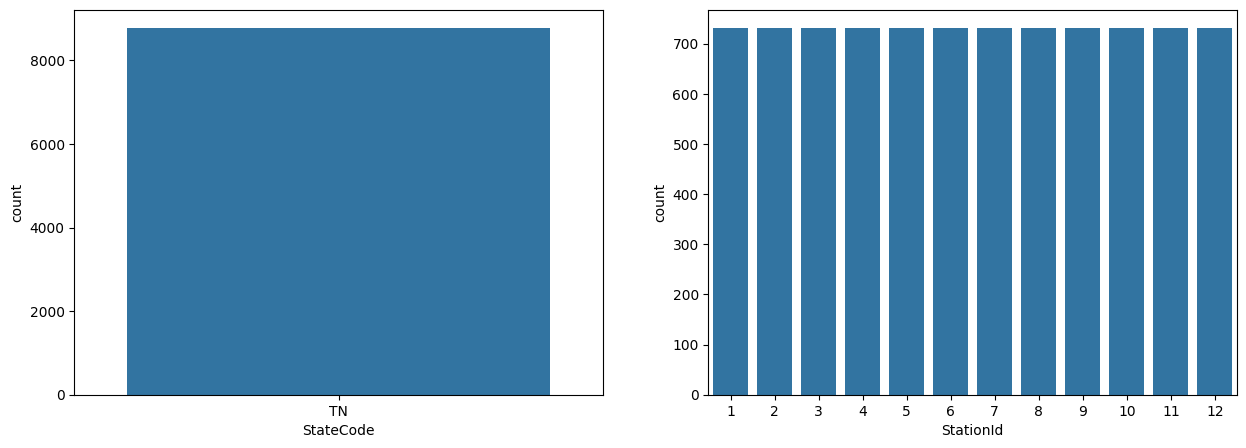

In [77]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(x=train.StateCode, ax=axes[0])
sns.countplot(x=train.StationId, ax=axes[1])
plt.show()

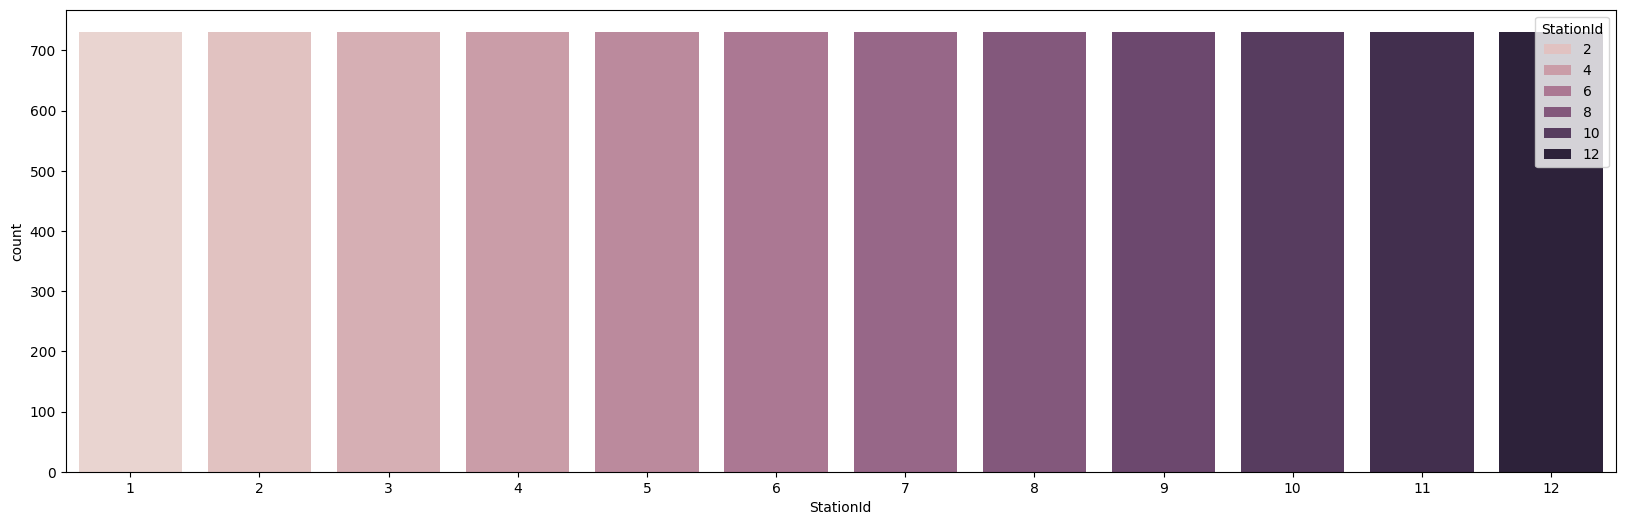

In [78]:
fig = plt.figure(figsize=(20,6))
sns.countplot(x=train.StationId, hue=train.StationId)
plt.show()

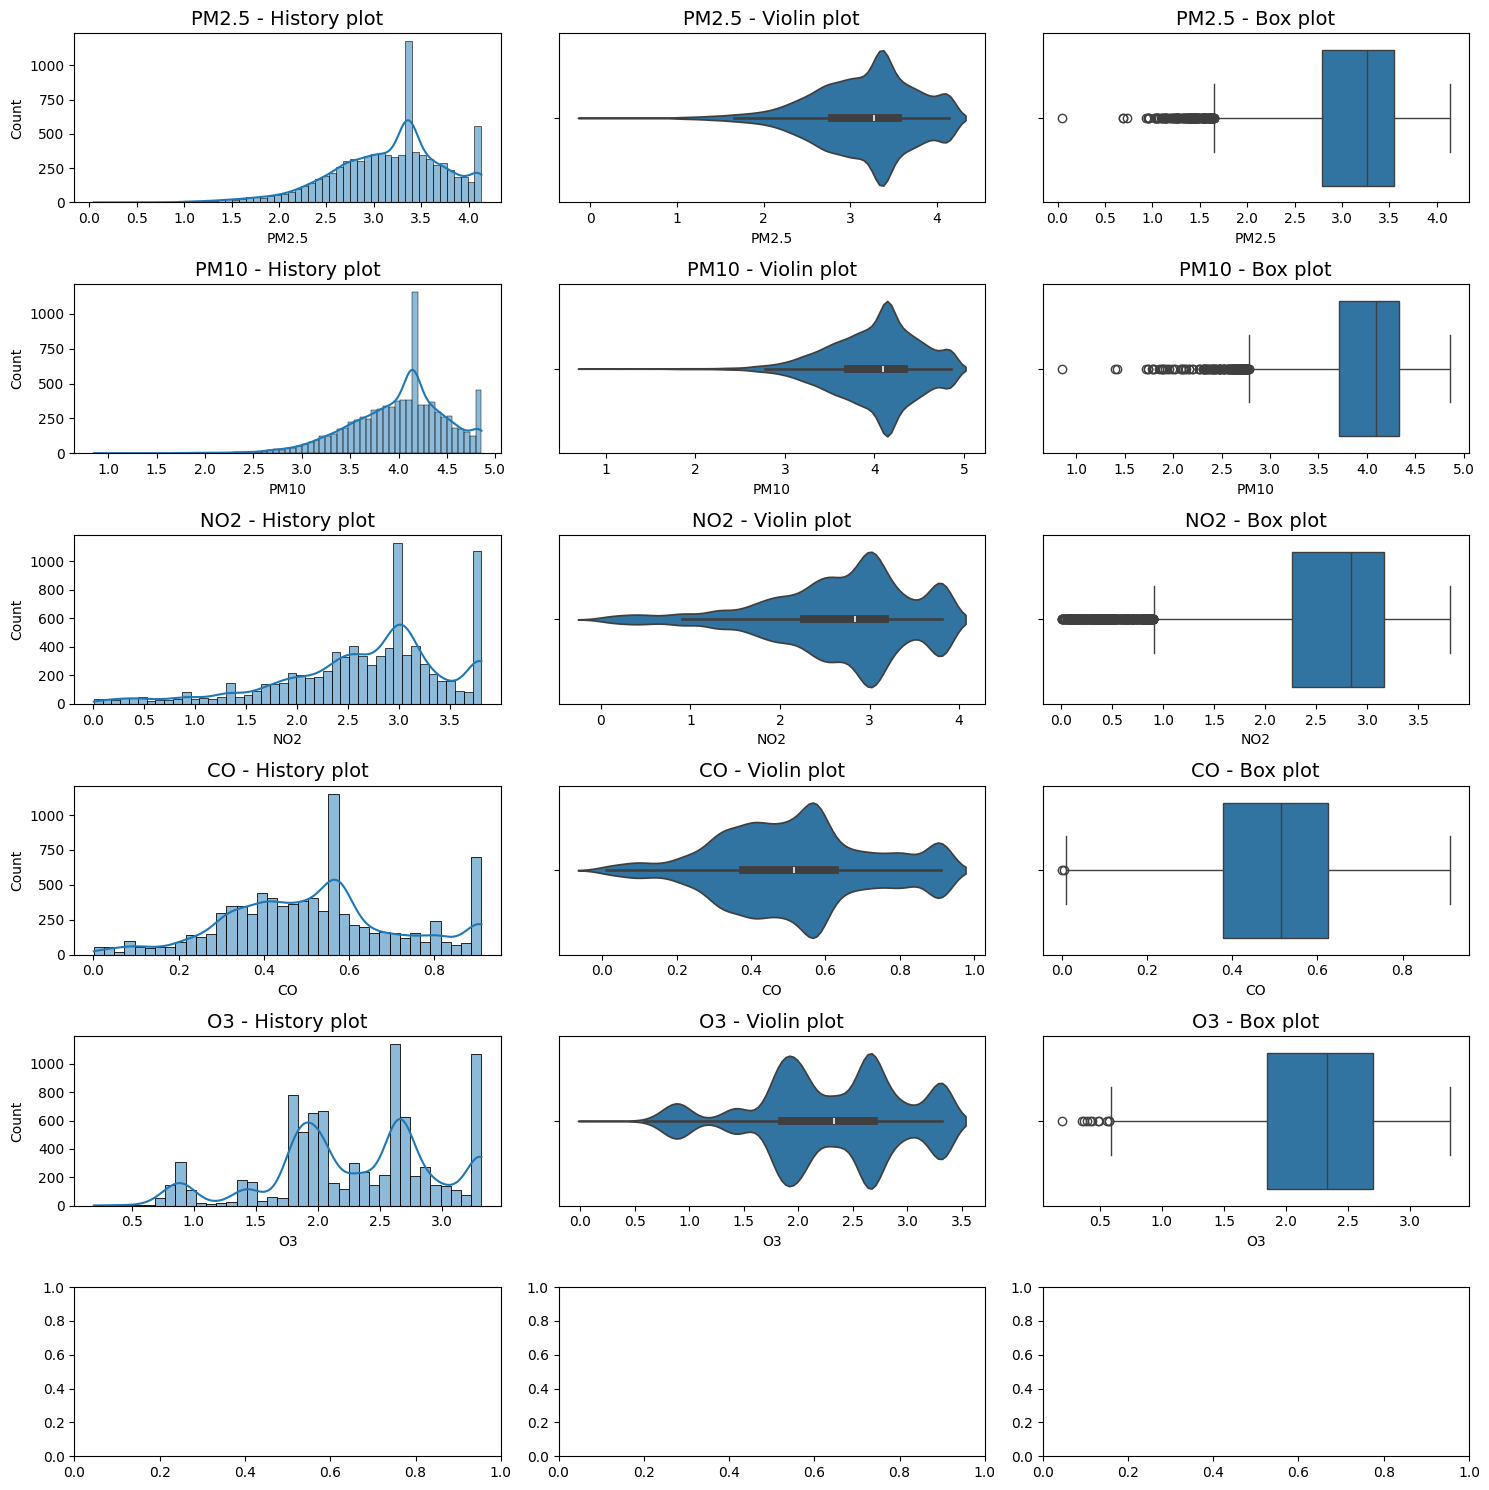

In [82]:
df = pd.read_csv("train_notprocessed.csv")
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,15))

for idx, col in enumerate(df.columns[4:-1]):
    sns.histplot(x=train[col], ax=axes[idx][0], kde=True)
    axes[idx][0].set_title(f"{col} - History plot", fontsize=14)

    sns.violinplot(x=train[col], ax=axes[idx][1])
    axes[idx][1].set_title(f"{col} - Violin plot", fontsize=14)

    sns.boxplot(x=train[col], ax=axes[idx][2])
    axes[idx][2].set_title(f"{col} - Box plot", fontsize=14)

plt.tight_layout()
plt.show()

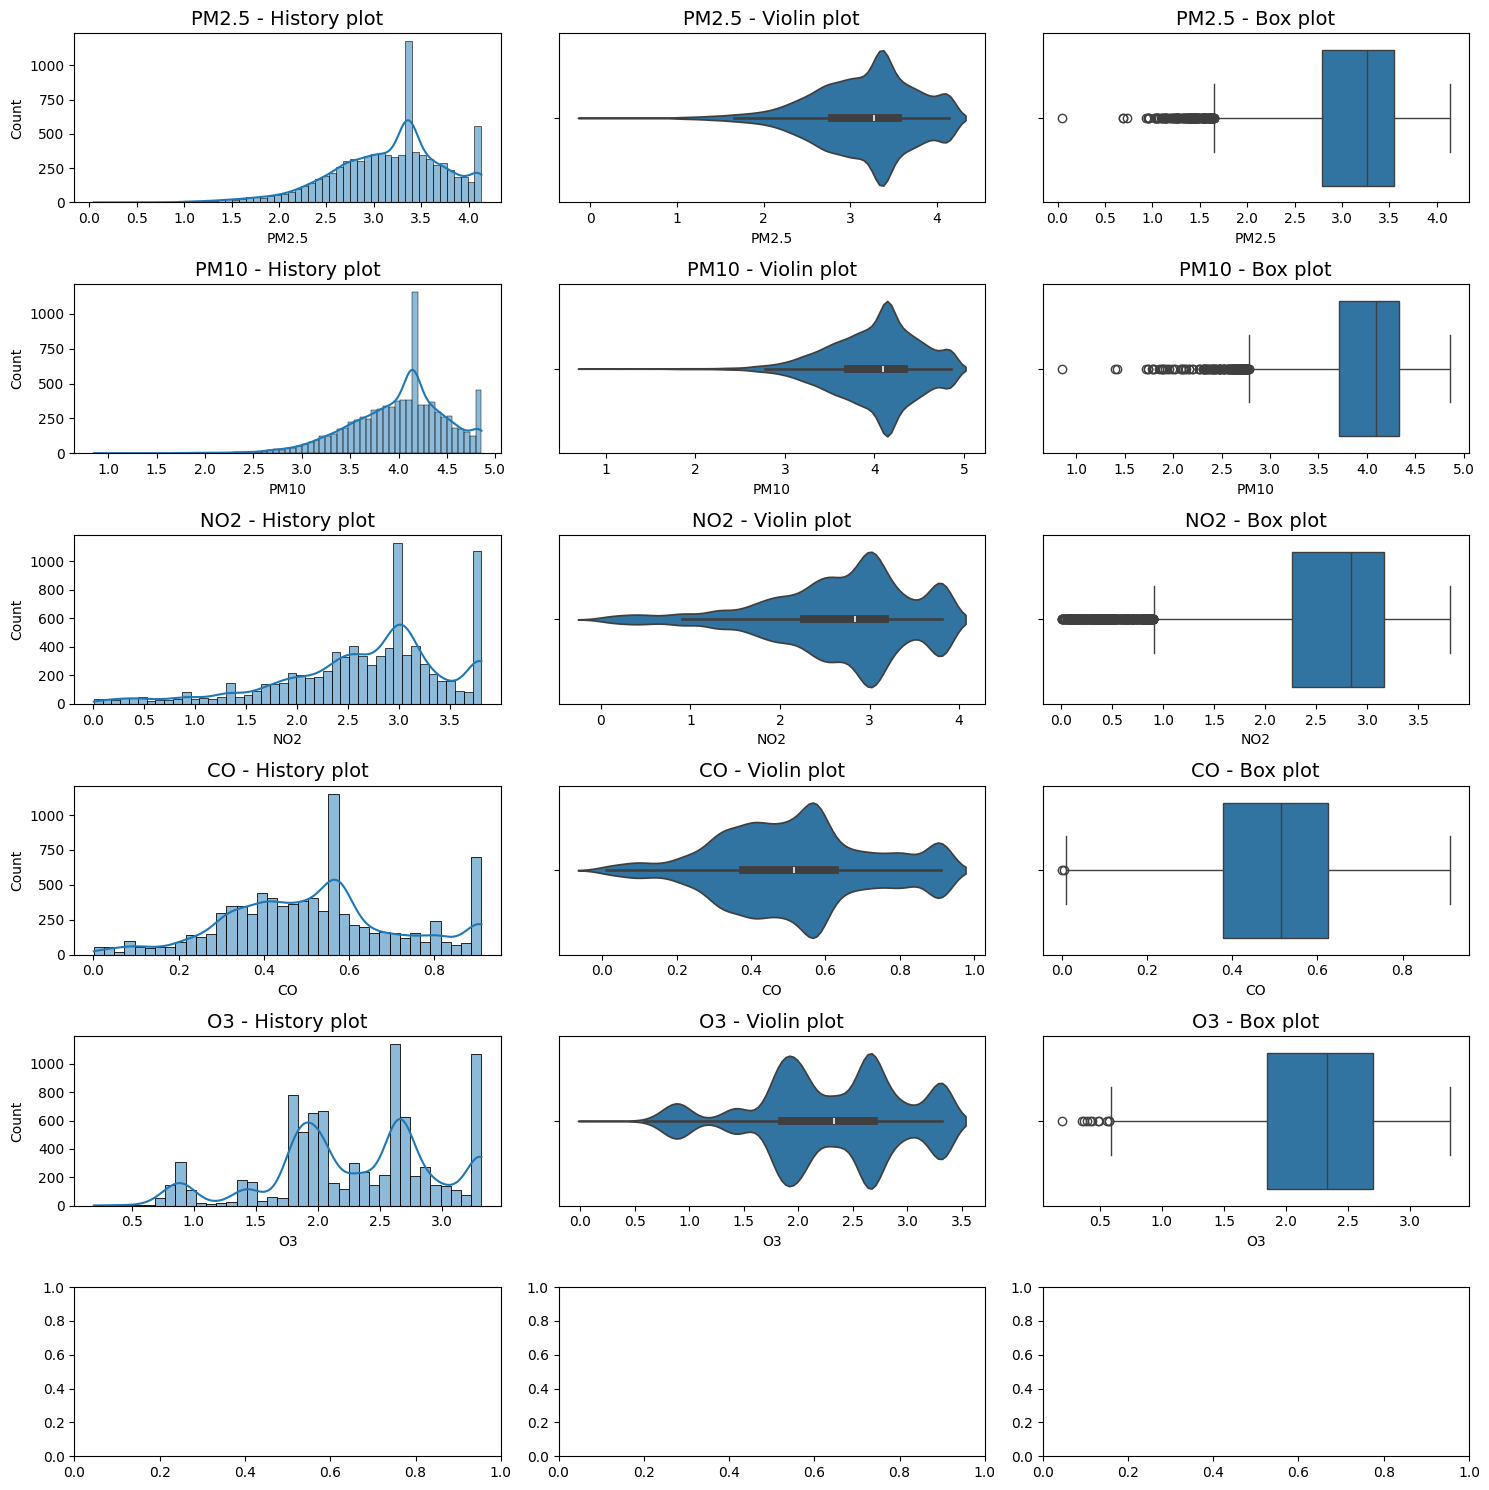

In [84]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15,15))

for idx, col in enumerate(train.columns[4:-2]):
    sns.histplot(x=train[col], ax=axes[idx][0], kde=True)
    axes[idx][0].set_title(f"{col} - History plot", fontsize=14)

    sns.violinplot(x=train[col], ax=axes[idx][1])
    axes[idx][1].set_title(f"{col} - Violin plot", fontsize=14)

    sns.boxplot(x=train[col], ax=axes[idx][2])
    axes[idx][2].set_title(f"{col} - Box plot", fontsize=14)

plt.tight_layout()
plt.show()

In [85]:
# Combine statecode and stationid
train['StateStation'] = train.apply(lambda x: x['StateCode'] + "-" + str(x['StationId']), axis=1)

In [86]:
train.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,NO2,CO,O3,year,month,StateStation
0,TN_1_2023-01-01,TN,1,2023-01-01,4.135584,4.818064,3.515784,0.674343,3.316692,2023,1,TN-1
1,TN_1_2023-01-02,TN,1,2023-01-02,4.135584,4.619193,3.349680,0.638357,3.242463,2023,1,TN-1
2,TN_1_2023-01-03,TN,1,2023-01-03,4.135584,4.785857,3.484471,0.656512,3.316692,2023,1,TN-1
3,TN_1_2023-01-04,TN,1,2023-01-04,4.135584,4.808580,3.730015,0.577101,3.316692,2023,1,TN-1
4,TN_1_2023-01-05,TN,1,2023-01-05,4.135584,4.645969,3.677926,0.592290,3.316692,2023,1,TN-1


In [87]:
# Make a copy of train and work on that
df = train.copy(deep=True)
df.set_index("Date", inplace=True)

In [88]:
df.head()

,ID_Date,StateCode,StationId,PM2.5,PM10,NO2,CO,O3,year,month,StateStation
Date,,,,,,,,,,,
2023-01-01,TN_1_2023-01-01,TN,1,4.135584,4.818064,3.515784,0.674343,3.316692,2023,1,TN-1
2023-01-02,TN_1_2023-01-02,TN,1,4.135584,4.619193,3.349680,0.638357,3.242463,2023,1,TN-1
2023-01-03,TN_1_2023-01-03,TN,1,4.135584,4.785857,3.484471,0.656512,3.316692,2023,1,TN-1
2023-01-04,TN_1_2023-01-04,TN,1,4.135584,4.808580,3.730015,0.577101,3.316692,2023,1,TN-1
2023-01-05,TN_1_2023-01-05,TN,1,4.135584,4.645969,3.677926,0.592290,3.316692,2023,1,TN-1


In [89]:
# Set formaters for date type in plots
years = mdates.YearLocator()
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%B')
yearsFmt = mdates.DateFormatter('\n%Y')

In [90]:
mapping = defaultdict(list)
for idx, code in enumerate(df.StateCode.unique()):
    for ss in df.StateStation.unique():
        if ss.startswith(code):
            mapping[code].append(ss)

### Correlation Plot

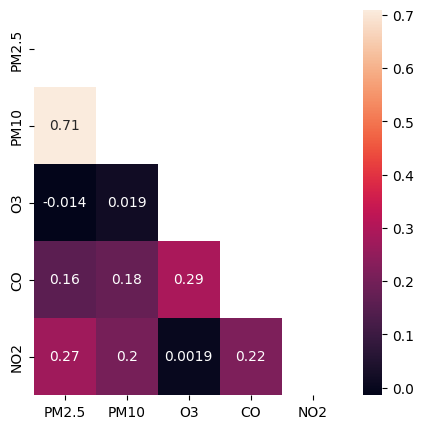

In [94]:
fig = plt.figure(figsize=(5,5))
mask = np.triu(np.ones_like(df[relevant_cols].corr()))
sns.heatmap(df[relevant_cols].corr(), annot=True, mask=mask)
plt.show()

In [96]:
df.head()

,ID_Date,StateCode,StationId,PM2.5,PM10,NO2,CO,O3,year,month,StateStation
Date,,,,,,,,,,,
2023-01-01,TN_1_2023-01-01,TN,1,4.135584,4.818064,3.515784,0.674343,3.316692,2023,1,TN-1
2023-01-02,TN_1_2023-01-02,TN,1,4.135584,4.619193,3.349680,0.638357,3.242463,2023,1,TN-1
2023-01-03,TN_1_2023-01-03,TN,1,4.135584,4.785857,3.484471,0.656512,3.316692,2023,1,TN-1
2023-01-04,TN_1_2023-01-04,TN,1,4.135584,4.808580,3.730015,0.577101,3.316692,2023,1,TN-1
2023-01-05,TN_1_2023-01-05,TN,1,4.135584,4.645969,3.677926,0.592290,3.316692,2023,1,TN-1


In [97]:
aqi_state_station_group = df.groupby(by="StateStation")

In [98]:
aqi_state_station_group[relevant_cols].corr()

PM2.5      PM10        O3        CO       NO2
StateStation                                                        
TN-1         PM2.5  1.000000  0.941072  0.260862  0.237778  0.206287
             PM10   0.941072  1.000000  0.192817  0.111530  0.216763
             O3     0.260862  0.192817  1.000000  0.143457  0.721717
             CO     0.237778  0.111530  0.143457  1.000000  0.214401
             NO2    0.206287  0.216763  0.721717  0.214401  1.000000
TN-10        PM2.5  1.000000  0.504276  0.409714  0.195894  0.717177
             PM10   0.504276  1.000000  0.089171  0.592402  0.593164
             O3     0.409714  0.089171  1.000000 -0.342044  0.642537
             CO     0.195894  0.592402 -0.342044  1.000000  0.239310
             NO2    0.717177  0.593164  0.642537  0.239310  1.000000
TN-11        PM2.5  1.000000  0.548405 -0.061857 -0.078228  0.047829
             PM10   0.548405  1.000000 -0.144857  0.014313 -0.064464
             O3    -0.061857 -0.144857  1.000000  0.036960  0.259857
             CO    -0.078228  0.014313  0.036960  1.000000 -0.232841
             NO2    0.047829 -0.064464  0.259857 -0.232841  1.000000
TN-12        PM2.5  1.000000  0.849714 -0.207641  0.225472  0.200051
             PM10   0.849714  1.000000 -0.181726  0.328533  0.244215
             O3    -0.207641 -0.181726  1.000000  0.132163 -0.232108
             CO     0.225472  0.328533  0.132163  1.000000  0.199261
             NO2    0.200051  0.244215 -0.232108  0.199261  1.000000
TN-2         PM2.5  1.000000  0.718083  0.095175 -0.104534  0.161031
             PM10   0.718083  1.000000  0.190549  0.244715 -0.088882
             O3     0.095175  0.190549  1.000000  0.336769 -0.092188
             CO    -0.104534  0.244715  0.336769  1.000000 -0.298469
             NO2    0.161031 -0.088882 -0.092188 -0.298469  1.000000
TN-3         PM2.5  1.000000  0.876633 -0.161504  0.088673  0.453007
             PM10   0.876633  1.000000 -0.100800  0.055968  0.395778
             O3    -0.161504 -0.100800  1.000000  0.012270  0.142814
             CO     0.088673  0.055968  0.012270  1.000000  0.208805
             NO2    0.453007  0.395778  0.142814  0.208805  1.000000
TN-4         PM2.5  1.000000  0.836961 -0.045381  0.054822  0.196475
             PM10   0.836961  1.000000  0.133172 -0.028738  0.392923
             O3    -0.045381  0.133172  1.000000 -0.021175  0.358321
             CO     0.054822 -0.028738 -0.021175  1.000000 -0.084160
             NO2    0.196475  0.392923  0.358321 -0.084160  1.000000
TN-5         PM2.5  1.000000  0.887234  0.082510  0.061263  0.370318
             PM10   0.887234  1.000000  0.147744  0.123976  0.374948
             O3     0.082510  0.147744  1.000000  0.539826  0.233657
             CO     0.061263  0.123976  0.539826  1.000000  0.303959
             NO2    0.370318  0.374948  0.233657  0.303959  1.000000
TN-6         PM2.5  1.000000  0.829491  0.109649  0.220350  0.283693
             PM10   0.829491  1.000000  0.044055  0.134808  0.393367
             O3     0.109649  0.044055  1.000000  0.224912 -0.009719
             CO     0.220350  0.134808  0.224912  1.000000  0.244172
             NO2    0.283693  0.393367 -0.009719  0.244172  1.000000
TN-7         PM2.5  1.000000  0.772674 -0.206307 -0.162413  0.260981
             PM10   0.772674  1.000000 -0.039227 -0.058858  0.132652
             O3    -0.206307 -0.039227  1.000000 -0.165908 -0.321074
             CO    -0.162413 -0.058858 -0.165908  1.000000  0.051300
             NO2    0.260981  0.132652 -0.321074  0.051300  1.000000
TN-8         PM2.5  1.000000  0.795150  0.047504  0.221308  0.160021
             PM10   0.795150  1.000000 -0.036737  0.340507  0.351042
             O3     0.047504 -0.036737  1.000000  0.133491  0.020485
             CO     0.221308  0.340507  0.133491  1.000000  0.473776
             NO2    0.160021  0.351042  0.020485  0.473776  1.000000
TN-9         PM2.5  1.000000  0.808277  0.031534 -0.042615 -0.121869
             PM10   0